# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  2.036804 -0.363022  0.0  0.590070 -1.029343 -1.815555  1  2   3.309190   
1 -1.310752 -0.696163  0.0  0.955902 -0.622965  0.165869  3  2  15.232299   
2  1.575498 -2.064303  0.0  0.274838 -2.789316 -0.021425  0  2   4.433265   
3  0.974531 -1.731926  1.0  0.538942 -0.851154  1.472589  3  3  25.716702   
4  1.200124 -1.653877  1.0  0.068665 -1.191374 -0.644186  3  1  14.929809   

            y  
0   46.034574  
1   33.732256  
2   27.264589  
3  180.461558  
4  116.342341  
True causal estimate is 8.934563973109583


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

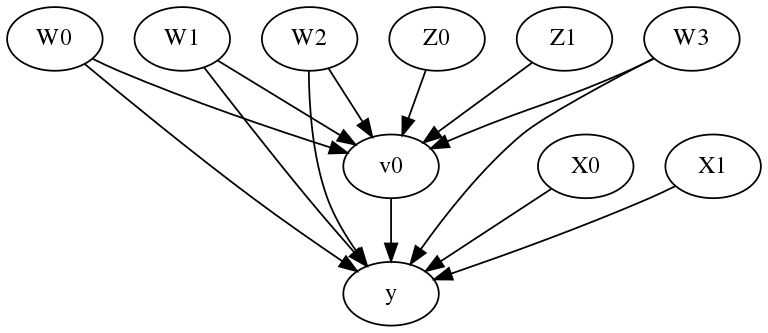

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W2,W0))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W2,W0))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 8.934998267459406
### Conditional Estimates
__categorical__X1  __categorical__X0
(-4.936, -1.812]   (-2.889, -0.093]     -2.221032
                   (-0.093, 0.475]       1.176441
                   (0.475, 0.982]        3.348562
                   (0.982, 1.557]        5.278263
                   (1.557, 4.397]        8.665254
(-1.812, -1.217]   (-2.889, -0.093]      1.155643
                   (-0.093, 0.475]       4.689474
                   (0.475, 0.982]        6.780788
                   (0.982, 1.557]        8.781189
                  

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-07-16 08:36:37.742652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-16 08:36:37.742847: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W2,W0))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 12.669497754794863
Effect estimates: [16.33651753  7.7521454   7.94534224 ... 12.29661733  9.63780804
  7.44466659]



In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 8.934563973109583


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W2,W0))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: 

## Estimate
Mean value: 8.867039635488743
Effect estimates: [16.27515942  2.08656177  7.72599434 ...  9.12024308 16.11805004
  7.41984655]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W2,W0))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 8.868234337836823
Effect estimates: [16.29326885  2.09092949  7.70177998 ...  9.12033023 16.16682175
  7.39651673]
95.0% confidence interval: (array([16.4063983 ,  1.90445356,  7.67752083, ...,  9.15745225,
       16.28312173,  7.37097213]), array([16.70436754,  2.15753769,  7.86322612, ...,  9.27611358,
       16.57675817,  7.54496402]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[12.48080544 14.27226555 16.4644416  14.39803239 12.23799072 12.45495623
 14.08048115 15.9048592  14.60020054 11.69750254]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     1.401991  1.476827  0.0  0.085080 -0.355250 -1.027663  0.054627   
1     0.280548 -0.889230  0.0  0.896308 -0.480969 -0.092452  0.361940   
2    -1.135378 -2.043865  0.0  0.295177 -2.069878 -1.039913 -1.359018   
3    -1.277284  0.030211  0.0  0.763085 -0.059427 -0.411922  0.492033   
4     0.073580 -1.095090  0.0  0.688423 -0.631144 -0.105212 -0.887453   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.550882 -0.631081  0.0  0.030775 -0.441399 -0.654300  0.733934   
9996 -1.186584  0.047641  0.0  0.094560 -0.188711 -0.594911  1.218346   
9997  1.567860 -0.260592  0.0  0.788353 -0.433868 -1.342471 -1.496272   
9998  0.611080 -0.440116  0.0  0.963568 -0.118741  0.082213 -0.463473   
9999 -0.648377  0.165077  0.0  0.902517  0.710945 -0.679579 -1.096693   

            W3  v0  y  
0    -1.256319   0  0  
1    -0.376891   1  1  
2     2.105592   0  0  
3     1.619679   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W1,W3,W2,W0))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W2,W0,U) = P(y|v0,W1,W3,W2,W0)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.502135141109137
Effect estimates: [0.58771972 0.48060344 0.40772862 ... 0.53252777 0.50372641 0.49445107]

True causal estimate is 0.2564


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-07-16 08:38:25.000165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-16 08:38:25.002986: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-16 08:38:25.003645: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AMSHAR-Z840): /proc/driver/nvidia/version does not exist
2022-07-16 08:38:25.012335: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:28 - loss: 79.5948

 15/313 [>.............................] - ETA: 1s - loss: 45.2419  

 31/313 [=>............................] - ETA: 0s - loss: 27.4586

 48/313 [===>..........................] - ETA: 0s - loss: 19.7274

 67/313 [=====>........................] - ETA: 0s - loss: 15.4177

 85/313 [=======>......................] - ETA: 0s - loss: 13.0400

103/313 [========>.....................] - ETA: 0s - loss: 11.4412

120/313 [==========>...................] - ETA: 0s - loss: 10.3512

138/313 [============>.................] - ETA: 0s - loss: 9.4834 

156/313 [=============>................] - ETA: 0s - loss: 8.8159

175/313 [===============>..............] - ETA: 0s - loss: 8.2373

194/313 [=================>............] - ETA: 0s - loss: 7.7676

213/313 [===================>..........] - ETA: 0s - loss: 7.3737

232/313 [=====================>........] - ETA: 0s - loss: 7.0313

251/313 [=======================>......] - ETA: 0s - loss: 6.7353

270/313 [========================>.....] - ETA: 0s - loss: 6.4801

290/313 [==========================>...] - ETA: 0s - loss: 6.2341

310/313 [============================>.] - ETA: 0s - loss: 6.0141

313/313 [==============================] - 2s 3ms/step - loss: 5.9842


Epoch 2/25
  1/313 [..............................] - ETA: 0s - loss: 2.7733

 20/313 [>.............................] - ETA: 0s - loss: 2.7122

 39/313 [==>...........................] - ETA: 0s - loss: 2.6962

 59/313 [====>.........................] - ETA: 0s - loss: 2.6613

 78/313 [======>.......................] - ETA: 0s - loss: 2.6427

 98/313 [========>.....................] - ETA: 0s - loss: 2.5984

117/313 [==========>...................] - ETA: 0s - loss: 2.5674

137/313 [============>.................] - ETA: 0s - loss: 2.5254

157/313 [==============>...............] - ETA: 0s - loss: 2.4893

176/313 [===============>..............] - ETA: 0s - loss: 2.4649

196/313 [=================>............] - ETA: 0s - loss: 2.4393

215/313 [===================>..........] - ETA: 0s - loss: 2.4204

234/313 [=====================>........] - ETA: 0s - loss: 2.4031

253/313 [=======================>......] - ETA: 0s - loss: 2.3851

273/313 [=========================>....] - ETA: 0s - loss: 2.3667

292/313 [==========================>...] - ETA: 0s - loss: 2.3501

311/313 [============================>.] - ETA: 0s - loss: 2.3325

313/313 [==============================] - 1s 3ms/step - loss: 2.3309


Epoch 3/25
  1/313 [..............................] - ETA: 0s - loss: 2.0050

 19/313 [>.............................] - ETA: 0s - loss: 2.0922

 38/313 [==>...........................] - ETA: 0s - loss: 2.0500

 57/313 [====>.........................] - ETA: 0s - loss: 2.0573

 76/313 [======>.......................] - ETA: 0s - loss: 2.0708

 95/313 [========>.....................] - ETA: 0s - loss: 2.0702

114/313 [=========>....................] - ETA: 0s - loss: 2.0724

132/313 [===========>..................] - ETA: 0s - loss: 2.0737

152/313 [=============>................] - ETA: 0s - loss: 2.0653

171/313 [===============>..............] - ETA: 0s - loss: 2.0515

190/313 [=================>............] - ETA: 0s - loss: 2.0518

209/313 [===================>..........] - ETA: 0s - loss: 2.0490

227/313 [====================>.........] - ETA: 0s - loss: 2.0463

246/313 [======================>.......] - ETA: 0s - loss: 2.0399

265/313 [========================>.....] - ETA: 0s - loss: 2.0377

285/313 [==========================>...] - ETA: 0s - loss: 2.0352

304/313 [============================>.] - ETA: 0s - loss: 2.0327

313/313 [==============================] - 1s 3ms/step - loss: 2.0298


Epoch 4/25
  1/313 [..............................] - ETA: 0s - loss: 1.8891

 20/313 [>.............................] - ETA: 0s - loss: 1.9881

 40/313 [==>...........................] - ETA: 0s - loss: 1.9780

 60/313 [====>.........................] - ETA: 0s - loss: 1.9857

 79/313 [======>.......................] - ETA: 0s - loss: 1.9752

 98/313 [========>.....................] - ETA: 0s - loss: 1.9639

117/313 [==========>...................] - ETA: 0s - loss: 1.9536

137/313 [============>.................] - ETA: 0s - loss: 1.9540

156/313 [=============>................] - ETA: 0s - loss: 1.9567

175/313 [===============>..............] - ETA: 0s - loss: 1.9534

194/313 [=================>............] - ETA: 0s - loss: 1.9564

213/313 [===================>..........] - ETA: 0s - loss: 1.9500

232/313 [=====================>........] - ETA: 0s - loss: 1.9438

251/313 [=======================>......] - ETA: 0s - loss: 1.9406

270/313 [========================>.....] - ETA: 0s - loss: 1.9371

290/313 [==========================>...] - ETA: 0s - loss: 1.9346

309/313 [============================>.] - ETA: 0s - loss: 1.9322

313/313 [==============================] - 1s 3ms/step - loss: 1.9318


Epoch 5/25
  1/313 [..............................] - ETA: 1s - loss: 1.8315

 20/313 [>.............................] - ETA: 0s - loss: 1.9772

 40/313 [==>...........................] - ETA: 0s - loss: 1.9468

 60/313 [====>.........................] - ETA: 0s - loss: 1.9263

 80/313 [======>.......................] - ETA: 0s - loss: 1.9297

 99/313 [========>.....................] - ETA: 0s - loss: 1.9308

118/313 [==========>...................] - ETA: 0s - loss: 1.9317

137/313 [============>.................] - ETA: 0s - loss: 1.9256

156/313 [=============>................] - ETA: 0s - loss: 1.9262

175/313 [===============>..............] - ETA: 0s - loss: 1.9146

195/313 [=================>............] - ETA: 0s - loss: 1.9090

215/313 [===================>..........] - ETA: 0s - loss: 1.9047

234/313 [=====================>........] - ETA: 0s - loss: 1.9031

253/313 [=======================>......] - ETA: 0s - loss: 1.8998

272/313 [=========================>....] - ETA: 0s - loss: 1.8997

291/313 [==========================>...] - ETA: 0s - loss: 1.9025

311/313 [============================>.] - ETA: 0s - loss: 1.9027

313/313 [==============================] - 1s 3ms/step - loss: 1.9022


Epoch 6/25
  1/313 [..............................] - ETA: 0s - loss: 1.7565

 20/313 [>.............................] - ETA: 0s - loss: 1.8524

 39/313 [==>...........................] - ETA: 0s - loss: 1.8604

 59/313 [====>.........................] - ETA: 0s - loss: 1.8602

 77/313 [======>.......................] - ETA: 0s - loss: 1.8644

 96/313 [========>.....................] - ETA: 0s - loss: 1.8580

115/313 [==========>...................] - ETA: 0s - loss: 1.8605

134/313 [===========>..................] - ETA: 0s - loss: 1.8686

154/313 [=============>................] - ETA: 0s - loss: 1.8660

173/313 [===============>..............] - ETA: 0s - loss: 1.8689

192/313 [=================>............] - ETA: 0s - loss: 1.8706

211/313 [===================>..........] - ETA: 0s - loss: 1.8755

231/313 [=====================>........] - ETA: 0s - loss: 1.8773

251/313 [=======================>......] - ETA: 0s - loss: 1.8761

270/313 [========================>.....] - ETA: 0s - loss: 1.8779

290/313 [==========================>...] - ETA: 0s - loss: 1.8733

310/313 [============================>.] - ETA: 0s - loss: 1.8753

313/313 [==============================] - 1s 3ms/step - loss: 1.8746


Epoch 7/25
  1/313 [..............................] - ETA: 1s - loss: 1.6945

 21/313 [=>............................] - ETA: 0s - loss: 1.8678

 41/313 [==>...........................] - ETA: 0s - loss: 1.8407

 60/313 [====>.........................] - ETA: 0s - loss: 1.8549

 79/313 [======>.......................] - ETA: 0s - loss: 1.8476

 99/313 [========>.....................] - ETA: 0s - loss: 1.8540

119/313 [==========>...................] - ETA: 0s - loss: 1.8453

138/313 [============>.................] - ETA: 0s - loss: 1.8486

157/313 [==============>...............] - ETA: 0s - loss: 1.8492

176/313 [===============>..............] - ETA: 0s - loss: 1.8489

196/313 [=================>............] - ETA: 0s - loss: 1.8427

215/313 [===================>..........] - ETA: 0s - loss: 1.8370

235/313 [=====================>........] - ETA: 0s - loss: 1.8430

255/313 [=======================>......] - ETA: 0s - loss: 1.8405

274/313 [=========================>....] - ETA: 0s - loss: 1.8382

293/313 [===========================>..] - ETA: 0s - loss: 1.8415

312/313 [============================>.] - ETA: 0s - loss: 1.8389

313/313 [==============================] - 1s 3ms/step - loss: 1.8392


Epoch 8/25
  1/313 [..............................] - ETA: 0s - loss: 1.5125

 21/313 [=>............................] - ETA: 0s - loss: 1.8180

 40/313 [==>...........................] - ETA: 0s - loss: 1.8297

 60/313 [====>.........................] - ETA: 0s - loss: 1.8479

 79/313 [======>.......................] - ETA: 0s - loss: 1.8612

 98/313 [========>.....................] - ETA: 0s - loss: 1.8519

117/313 [==========>...................] - ETA: 0s - loss: 1.8492

136/313 [============>.................] - ETA: 0s - loss: 1.8432

156/313 [=============>................] - ETA: 0s - loss: 1.8409

175/313 [===============>..............] - ETA: 0s - loss: 1.8457

195/313 [=================>............] - ETA: 0s - loss: 1.8438

215/313 [===================>..........] - ETA: 0s - loss: 1.8423

235/313 [=====================>........] - ETA: 0s - loss: 1.8401

255/313 [=======================>......] - ETA: 0s - loss: 1.8400

275/313 [=========================>....] - ETA: 0s - loss: 1.8407

295/313 [===========================>..] - ETA: 0s - loss: 1.8394

313/313 [==============================] - 1s 3ms/step - loss: 1.8333


Epoch 9/25
  1/313 [..............................] - ETA: 0s - loss: 1.7229

 21/313 [=>............................] - ETA: 0s - loss: 1.8907

 41/313 [==>...........................] - ETA: 0s - loss: 1.8628

 61/313 [====>.........................] - ETA: 0s - loss: 1.8489

 81/313 [======>.......................] - ETA: 0s - loss: 1.8385

101/313 [========>.....................] - ETA: 0s - loss: 1.8278

120/313 [==========>...................] - ETA: 0s - loss: 1.8291

140/313 [============>.................] - ETA: 0s - loss: 1.8288

159/313 [==============>...............] - ETA: 0s - loss: 1.8353

178/313 [================>.............] - ETA: 0s - loss: 1.8385

197/313 [=================>............] - ETA: 0s - loss: 1.8403

217/313 [===================>..........] - ETA: 0s - loss: 1.8418

237/313 [=====================>........] - ETA: 0s - loss: 1.8381

257/313 [=======================>......] - ETA: 0s - loss: 1.8353

277/313 [=========================>....] - ETA: 0s - loss: 1.8317

297/313 [===========================>..] - ETA: 0s - loss: 1.8270

313/313 [==============================] - 1s 3ms/step - loss: 1.8262


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 1.9551

 20/313 [>.............................] - ETA: 0s - loss: 1.8250

 39/313 [==>...........................] - ETA: 0s - loss: 1.8321

 58/313 [====>.........................] - ETA: 0s - loss: 1.8149

 77/313 [======>.......................] - ETA: 0s - loss: 1.8107

 96/313 [========>.....................] - ETA: 0s - loss: 1.8037

116/313 [==========>...................] - ETA: 0s - loss: 1.8049

135/313 [===========>..................] - ETA: 0s - loss: 1.8022

154/313 [=============>................] - ETA: 0s - loss: 1.8109

174/313 [===============>..............] - ETA: 0s - loss: 1.8108

193/313 [=================>............] - ETA: 0s - loss: 1.8128

213/313 [===================>..........] - ETA: 0s - loss: 1.8140

233/313 [=====================>........] - ETA: 0s - loss: 1.8125

253/313 [=======================>......] - ETA: 0s - loss: 1.8181

273/313 [=========================>....] - ETA: 0s - loss: 1.8206

293/313 [===========================>..] - ETA: 0s - loss: 1.8199

313/313 [==============================] - ETA: 0s - loss: 1.8155

313/313 [==============================] - 1s 3ms/step - loss: 1.8155


Epoch 11/25
  1/313 [..............................] - ETA: 1s - loss: 2.0078

 21/313 [=>............................] - ETA: 0s - loss: 1.8319

 41/313 [==>...........................] - ETA: 0s - loss: 1.8349

 61/313 [====>.........................] - ETA: 0s - loss: 1.8191

 80/313 [======>.......................] - ETA: 0s - loss: 1.7950

100/313 [========>.....................] - ETA: 0s - loss: 1.7986

120/313 [==========>...................] - ETA: 0s - loss: 1.7978

140/313 [============>.................] - ETA: 0s - loss: 1.8045

160/313 [==============>...............] - ETA: 0s - loss: 1.8072

179/313 [================>.............] - ETA: 0s - loss: 1.8021

198/313 [=================>............] - ETA: 0s - loss: 1.8061

217/313 [===================>..........] - ETA: 0s - loss: 1.8038

236/313 [=====================>........] - ETA: 0s - loss: 1.8039

255/313 [=======================>......] - ETA: 0s - loss: 1.8069

274/313 [=========================>....] - ETA: 0s - loss: 1.8095

294/313 [===========================>..] - ETA: 0s - loss: 1.8076

313/313 [==============================] - 1s 3ms/step - loss: 1.8069


Epoch 12/25
  1/313 [..............................] - ETA: 0s - loss: 1.6354

 21/313 [=>............................] - ETA: 0s - loss: 1.7972

 41/313 [==>...........................] - ETA: 0s - loss: 1.8003

 61/313 [====>.........................] - ETA: 0s - loss: 1.8107

 81/313 [======>.......................] - ETA: 0s - loss: 1.8058

101/313 [========>.....................] - ETA: 0s - loss: 1.7989

120/313 [==========>...................] - ETA: 0s - loss: 1.7970

140/313 [============>.................] - ETA: 0s - loss: 1.7936

160/313 [==============>...............] - ETA: 0s - loss: 1.7908

180/313 [================>.............] - ETA: 0s - loss: 1.7904

200/313 [==================>...........] - ETA: 0s - loss: 1.7898

219/313 [===================>..........] - ETA: 0s - loss: 1.7938

239/313 [=====================>........] - ETA: 0s - loss: 1.7940

259/313 [=======================>......] - ETA: 0s - loss: 1.7921

279/313 [=========================>....] - ETA: 0s - loss: 1.7905

299/313 [===========================>..] - ETA: 0s - loss: 1.7907

313/313 [==============================] - 1s 3ms/step - loss: 1.7894


Epoch 13/25
  1/313 [..............................] - ETA: 1s - loss: 1.5891

 21/313 [=>............................] - ETA: 0s - loss: 1.7786

 39/313 [==>...........................] - ETA: 0s - loss: 1.7673

 58/313 [====>.........................] - ETA: 0s - loss: 1.7593

 78/313 [======>.......................] - ETA: 0s - loss: 1.7797

 98/313 [========>.....................] - ETA: 0s - loss: 1.7877

117/313 [==========>...................] - ETA: 0s - loss: 1.7845

136/313 [============>.................] - ETA: 0s - loss: 1.7915

155/313 [=============>................] - ETA: 0s - loss: 1.7926

174/313 [===============>..............] - ETA: 0s - loss: 1.7965

193/313 [=================>............] - ETA: 0s - loss: 1.7917

213/313 [===================>..........] - ETA: 0s - loss: 1.7854

233/313 [=====================>........] - ETA: 0s - loss: 1.7847

252/313 [=======================>......] - ETA: 0s - loss: 1.7860

272/313 [=========================>....] - ETA: 0s - loss: 1.7822

292/313 [==========================>...] - ETA: 0s - loss: 1.7819

311/313 [============================>.] - ETA: 0s - loss: 1.7773

313/313 [==============================] - 1s 3ms/step - loss: 1.7770


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 1.9428

 20/313 [>.............................] - ETA: 0s - loss: 1.7681

 40/313 [==>...........................] - ETA: 0s - loss: 1.7710

 59/313 [====>.........................] - ETA: 0s - loss: 1.7634

 79/313 [======>.......................] - ETA: 0s - loss: 1.7762

 99/313 [========>.....................] - ETA: 0s - loss: 1.7760

119/313 [==========>...................] - ETA: 0s - loss: 1.7605

139/313 [============>.................] - ETA: 0s - loss: 1.7616

159/313 [==============>...............] - ETA: 0s - loss: 1.7609

179/313 [================>.............] - ETA: 0s - loss: 1.7642

199/313 [==================>...........] - ETA: 0s - loss: 1.7705

218/313 [===================>..........] - ETA: 0s - loss: 1.7764

237/313 [=====================>........] - ETA: 0s - loss: 1.7757

256/313 [=======================>......] - ETA: 0s - loss: 1.7739

276/313 [=========================>....] - ETA: 0s - loss: 1.7745

296/313 [===========================>..] - ETA: 0s - loss: 1.7753

313/313 [==============================] - 1s 3ms/step - loss: 1.7768


Epoch 15/25
  1/313 [..............................] - ETA: 0s - loss: 1.8077

 21/313 [=>............................] - ETA: 0s - loss: 1.7699

 40/313 [==>...........................] - ETA: 0s - loss: 1.7518

 59/313 [====>.........................] - ETA: 0s - loss: 1.7845

 78/313 [======>.......................] - ETA: 0s - loss: 1.7826

 97/313 [========>.....................] - ETA: 0s - loss: 1.7888

118/313 [==========>...................] - ETA: 0s - loss: 1.7891

137/313 [============>.................] - ETA: 0s - loss: 1.7935

156/313 [=============>................] - ETA: 0s - loss: 1.7905

175/313 [===============>..............] - ETA: 0s - loss: 1.7860

195/313 [=================>............] - ETA: 0s - loss: 1.7852

214/313 [===================>..........] - ETA: 0s - loss: 1.7837

233/313 [=====================>........] - ETA: 0s - loss: 1.7837

253/313 [=======================>......] - ETA: 0s - loss: 1.7783

272/313 [=========================>....] - ETA: 0s - loss: 1.7777

292/313 [==========================>...] - ETA: 0s - loss: 1.7771

311/313 [============================>.] - ETA: 0s - loss: 1.7759

313/313 [==============================] - 1s 3ms/step - loss: 1.7750


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 1.7565

 21/313 [=>............................] - ETA: 0s - loss: 1.7597

 40/313 [==>...........................] - ETA: 0s - loss: 1.7675

 59/313 [====>.........................] - ETA: 0s - loss: 1.7823

 78/313 [======>.......................] - ETA: 0s - loss: 1.7782

 98/313 [========>.....................] - ETA: 0s - loss: 1.7766

117/313 [==========>...................] - ETA: 0s - loss: 1.7758

136/313 [============>.................] - ETA: 0s - loss: 1.7753

156/313 [=============>................] - ETA: 0s - loss: 1.7748

176/313 [===============>..............] - ETA: 0s - loss: 1.7663

195/313 [=================>............] - ETA: 0s - loss: 1.7645

216/313 [===================>..........] - ETA: 0s - loss: 1.7644

236/313 [=====================>........] - ETA: 0s - loss: 1.7645

256/313 [=======================>......] - ETA: 0s - loss: 1.7630

276/313 [=========================>....] - ETA: 0s - loss: 1.7609

295/313 [===========================>..] - ETA: 0s - loss: 1.7591

313/313 [==============================] - 1s 3ms/step - loss: 1.7588


Epoch 17/25
  1/313 [..............................] - ETA: 1s - loss: 1.7320

 20/313 [>.............................] - ETA: 0s - loss: 1.8045

 40/313 [==>...........................] - ETA: 0s - loss: 1.7934

 60/313 [====>.........................] - ETA: 0s - loss: 1.7802

 80/313 [======>.......................] - ETA: 0s - loss: 1.7719

100/313 [========>.....................] - ETA: 0s - loss: 1.7757

119/313 [==========>...................] - ETA: 0s - loss: 1.7762

139/313 [============>.................] - ETA: 0s - loss: 1.7737

158/313 [==============>...............] - ETA: 0s - loss: 1.7710

178/313 [================>.............] - ETA: 0s - loss: 1.7690

197/313 [=================>............] - ETA: 0s - loss: 1.7690

217/313 [===================>..........] - ETA: 0s - loss: 1.7702

237/313 [=====================>........] - ETA: 0s - loss: 1.7696

257/313 [=======================>......] - ETA: 0s - loss: 1.7669

277/313 [=========================>....] - ETA: 0s - loss: 1.7626

297/313 [===========================>..] - ETA: 0s - loss: 1.7626

313/313 [==============================] - 1s 3ms/step - loss: 1.7637


Epoch 18/25
  1/313 [..............................] - ETA: 0s - loss: 1.6769

 20/313 [>.............................] - ETA: 0s - loss: 1.7525

 40/313 [==>...........................] - ETA: 0s - loss: 1.7453

 59/313 [====>.........................] - ETA: 0s - loss: 1.7628

 78/313 [======>.......................] - ETA: 0s - loss: 1.7527

 98/313 [========>.....................] - ETA: 0s - loss: 1.7559

117/313 [==========>...................] - ETA: 0s - loss: 1.7518

137/313 [============>.................] - ETA: 0s - loss: 1.7538

156/313 [=============>................] - ETA: 0s - loss: 1.7511

176/313 [===============>..............] - ETA: 0s - loss: 1.7500

196/313 [=================>............] - ETA: 0s - loss: 1.7551

216/313 [===================>..........] - ETA: 0s - loss: 1.7546

235/313 [=====================>........] - ETA: 0s - loss: 1.7515

255/313 [=======================>......] - ETA: 0s - loss: 1.7533

276/313 [=========================>....] - ETA: 0s - loss: 1.7535

296/313 [===========================>..] - ETA: 0s - loss: 1.7552

313/313 [==============================] - 1s 3ms/step - loss: 1.7542


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 1.6332

 21/313 [=>............................]

 - ETA: 0s - loss: 1.6835

 42/313 [===>..........................] - ETA: 0s - loss: 1.7240

 62/313 [====>.........................] - ETA: 0s - loss: 1.7460

 82/313 [======>.......................] - ETA: 0s - loss: 1.7325

103/313 [========>.....................] - ETA: 0s - loss: 1.7350

123/313 [==========>...................] - ETA: 0s - loss: 1.7434

143/313 [============>.................] - ETA: 0s - loss: 1.7370

163/313 [==============>...............] - ETA: 0s - loss: 1.7414

184/313 [================>.............] - ETA: 0s - loss: 1.7393

204/313 [==================>...........] - ETA: 0s - loss: 1.7376

224/313 [====================>.........] - ETA: 0s - loss: 1.7399

244/313 [======================>.......] - ETA: 0s - loss: 1.7386

264/313 [========================>.....] - ETA: 0s - loss: 1.7358

284/313 [==========================>...] - ETA: 0s - loss: 1.7380

304/313 [============================>.] - ETA: 0s - loss: 1.7395

313/313 [==============================] - 1s 3ms/step - loss: 1.7408


Epoch 20/25
  1/313 [..............................] - ETA: 1s - loss: 1.5786

 21/313 [=>............................] - ETA: 0s - loss: 1.7369

 42/313 [===>..........................] - ETA: 0s - loss: 1.7387

 62/313 [====>.........................] - ETA: 0s - loss: 1.7303

 82/313 [======>.......................] - ETA: 0s - loss: 1.7478

102/313 [========>.....................] - ETA: 0s - loss: 1.7472

122/313 [==========>...................] - ETA: 0s - loss: 1.7452

142/313 [============>.................] - ETA: 0s - loss: 1.7482

162/313 [==============>...............] - ETA: 0s - loss: 1.7437

183/313 [================>.............] - ETA: 0s - loss: 1.7399

203/313 [==================>...........] - ETA: 0s - loss: 1.7425

223/313 [====================>.........] - ETA: 0s - loss: 1.7412

243/313 [======================>.......] - ETA: 0s - loss: 1.7416

263/313 [========================>.....] - ETA: 0s - loss: 1.7419

283/313 [==========================>...] - ETA: 0s - loss: 1.7413

303/313 [============================>.] - ETA: 0s - loss: 1.7434

313/313 [==============================] - 1s 3ms/step - loss: 1.7434


Epoch 21/25
  1/313 [..............................] - ETA: 0s - loss: 1.7439

 21/313 [=>............................] - ETA: 0s - loss: 1.7186

 41/313 [==>...........................] - ETA: 0s - loss: 1.7386

 61/313 [====>.........................] - ETA: 0s - loss: 1.7496

 81/313 [======>.......................] - ETA: 0s - loss: 1.7542

101/313 [========>.....................] - ETA: 0s - loss: 1.7553

121/313 [==========>...................] - ETA: 0s - loss: 1.7461

141/313 [============>.................] - ETA: 0s - loss: 1.7543

161/313 [==============>...............] - ETA: 0s - loss: 1.7515

182/313 [================>.............] - ETA: 0s - loss: 1.7461

202/313 [==================>...........] - ETA: 0s - loss: 1.7431

223/313 [====================>.........] - ETA: 0s - loss: 1.7392

243/313 [======================>.......] - ETA: 0s - loss: 1.7408

263/313 [========================>.....] - ETA: 0s - loss: 1.7383

283/313 [==========================>...] - ETA: 0s - loss: 1.7387

303/313 [============================>.] - ETA: 0s - loss: 1.7370

313/313 [==============================] - 1s 3ms/step - loss: 1.7351


Epoch 22/25
  1/313 [..............................] - ETA: 0s - loss: 1.7817

 21/313 [=>............................] - ETA: 0s - loss: 1.7108

 41/313 [==>...........................] - ETA: 0s - loss: 1.7320

 61/313 [====>.........................] - ETA: 0s - loss: 1.7493

 81/313 [======>.......................] - ETA: 0s - loss: 1.7448

102/313 [========>.....................] - ETA: 0s - loss: 1.7483

122/313 [==========>...................] - ETA: 0s - loss: 1.7532

143/313 [============>.................] - ETA: 0s - loss: 1.7523

163/313 [==============>...............] - ETA: 0s - loss: 1.7519

183/313 [================>.............] - ETA: 0s - loss: 1.7477

203/313 [==================>...........] - ETA: 0s - loss: 1.7448

224/313 [====================>.........] - ETA: 0s - loss: 1.7441

244/313 [======================>.......] - ETA: 0s - loss: 1.7475

264/313 [========================>.....] - ETA: 0s - loss: 1.7446

284/313 [==========================>...] - ETA: 0s - loss: 1.7421

305/313 [============================>.] - ETA: 0s - loss: 1.7416

313/313 [==============================] - 1s 3ms/step - loss: 1.7415


Epoch 23/25
  1/313 [..............................] - ETA: 0s - loss: 1.7628

 22/313 [=>............................] - ETA: 0s - loss: 1.7464

 42/313 [===>..........................] - ETA: 0s - loss: 1.7444

 62/313 [====>.........................] - ETA: 0s - loss: 1.7314

 82/313 [======>.......................] - ETA: 0s - loss: 1.7257

102/313 [========>.....................] - ETA: 0s - loss: 1.7375

122/313 [==========>...................] - ETA: 0s - loss: 1.7418

142/313 [============>.................] - ETA: 0s - loss: 1.7436

162/313 [==============>...............] - ETA: 0s - loss: 1.7401

182/313 [================>.............] - ETA: 0s - loss: 1.7397

202/313 [==================>...........] - ETA: 0s - loss: 1.7401

224/313 [====================>.........] - ETA: 0s - loss: 1.7404

246/313 [======================>.......] - ETA: 0s - loss: 1.7426

266/313 [========================>.....] - ETA: 0s - loss: 1.7428

287/313 [==========================>...] - ETA: 0s - loss: 1.7366

307/313 [============================>.] - ETA: 0s - loss: 1.7361

313/313 [==============================] - 1s 3ms/step - loss: 1.7373


Epoch 24/25
  1/313 [..............................] - ETA: 0s - loss: 1.6195

 21/313 [=>............................] - ETA: 0s - loss: 1.7215

 41/313 [==>...........................] - ETA: 0s - loss: 1.7421

 61/313 [====>.........................] - ETA: 0s - loss: 1.7506

 82/313 [======>.......................] - ETA: 0s - loss: 1.7317

103/313 [========>.....................] - ETA: 0s - loss: 1.7258

124/313 [==========>...................] - ETA: 0s - loss: 1.7308

144/313 [============>.................] - ETA: 0s - loss: 1.7350

165/313 [==============>...............] - ETA: 0s - loss: 1.7316

186/313 [================>.............] - ETA: 0s - loss: 1.7364

206/313 [==================>...........] - ETA: 0s - loss: 1.7385

226/313 [====================>.........] - ETA: 0s - loss: 1.7407

246/313 [======================>.......] - ETA: 0s - loss: 1.7390

267/313 [========================>.....] - ETA: 0s - loss: 1.7384

287/313 [==========================>...] - ETA: 0s - loss: 1.7360

308/313 [============================>.] - ETA: 0s - loss: 1.7351

313/313 [==============================] - 1s 3ms/step - loss: 1.7339


Epoch 25/25
  1/313 [..............................] - ETA: 0s - loss: 1.8706

 21/313 [=>............................] - ETA: 0s - loss: 1.7231

 42/313 [===>..........................] - ETA: 0s - loss: 1.7316

 62/313 [====>.........................] - ETA: 0s - loss: 1.7270

 82/313 [======>.......................] - ETA: 0s - loss: 1.7127

103/313 [========>.....................] - ETA: 0s - loss: 1.7191

124/313 [==========>...................] - ETA: 0s - loss: 1.7242

145/313 [============>.................] - ETA: 0s - loss: 1.7185

166/313 [==============>...............] - ETA: 0s - loss: 1.7194

187/313 [================>.............] - ETA: 0s - loss: 1.7205

208/313 [==================>...........] - ETA: 0s - loss: 1.7193

228/313 [====================>.........] - ETA: 0s - loss: 1.7201

249/313 [======================>.......] - ETA: 0s - loss: 1.7220

270/313 [========================>.....] - ETA: 0s - loss: 1.7240

290/313 [==========================>...] - ETA: 0s - loss: 1.7250

311/313 [============================>.] - ETA: 0s - loss: 1.7256

313/313 [==============================] - 1s 2ms/step - loss: 1.7251


Epoch 1/25


  1/313 [..............................] - ETA: 4:14 - loss: 22654.5410

 11/313 [>.............................] - ETA: 1s - loss: 26618.9941  

 22/313 [=>............................] - ETA: 1s - loss: 24134.1816

 32/313 [==>...........................] - ETA: 1s - loss: 23356.8730

 45/313 [===>..........................] - ETA: 1s - loss: 21122.7676

 58/313 [====>.........................] - ETA: 1s - loss: 18729.1074

 70/313 [=====>........................] - ETA: 1s - loss: 16904.1250

 82/313 [======>.......................] - ETA: 1s - loss: 15740.6191

 96/313 [========>.....................] - ETA: 0s - loss: 14523.0166

109/313 [=========>....................] - ETA: 0s - loss: 13854.5527

123/313 [==========>...................] - ETA: 0s - loss: 13219.8721

137/313 [============>.................] - ETA: 0s - loss: 12605.5762

151/313 [=============>................] - ETA: 0s - loss: 12084.4375

165/313 [==============>...............] - ETA: 0s - loss: 11633.6016

179/313 [================>.............] - ETA: 0s - loss: 11181.1631

193/313 [=================>............] - ETA: 0s - loss: 10831.0840

207/313 [==================>...........] - ETA: 0s - loss: 10449.9746

222/313 [====================>.........] - ETA: 0s - loss: 10139.5859

236/313 [=====================>........] - ETA: 0s - loss: 9793.6729 

250/313 [======================>.......] - ETA: 0s - loss: 9478.9932

264/313 [========================>.....] - ETA: 0s - loss: 9215.3145

278/313 [=========================>....] - ETA: 0s - loss: 8916.4131

292/313 [==========================>...] - ETA: 0s - loss: 8683.2129

306/313 [============================>.] - ETA: 0s - loss: 8462.0059

313/313 [==============================] - 2s 4ms/step - loss: 8370.5137


Epoch 2/25
  1/313 [..............................] - ETA: 1s - loss: 5549.3447

 15/313 [>.............................] - ETA: 1s - loss: 4420.4292

 29/313 [=>............................] - ETA: 1s - loss: 3877.5527

 43/313 [===>..........................] - ETA: 1s - loss: 3736.1963

 57/313 [====>.........................] - ETA: 0s - loss: 3511.3750

 71/313 [=====>........................] - ETA: 0s - loss: 3552.7517

 85/313 [=======>......................] - ETA: 0s - loss: 3559.1492

100/313 [========>.....................] - ETA: 0s - loss: 3498.0461

114/313 [=========>....................] - ETA: 0s - loss: 3532.0845

128/313 [===========>..................] - ETA: 0s - loss: 3502.0081

142/313 [============>.................] - ETA: 0s - loss: 3497.4570

156/313 [=============>................] - ETA: 0s - loss: 3486.2380

170/313 [===============>..............] - ETA: 0s - loss: 3493.2166

184/313 [================>.............] - ETA: 0s - loss: 3506.4373

198/313 [=================>............] - ETA: 0s - loss: 3540.1475

212/313 [===================>..........] - ETA: 0s - loss: 3545.6006

226/313 [====================>.........] - ETA: 0s - loss: 3519.7661

240/313 [======================>.......] - ETA: 0s - loss: 3533.8989

254/313 [=======================>......] - ETA: 0s - loss: 3553.9443

268/313 [========================>.....] - ETA: 0s - loss: 3567.4614

282/313 [==========================>...] - ETA: 0s - loss: 3584.2996

296/313 [===========================>..] - ETA: 0s - loss: 3584.9092

311/313 [============================>.] - ETA: 0s - loss: 3607.8999

313/313 [==============================] - 1s 4ms/step - loss: 3600.0454


Epoch 3/25
  1/313 [..............................] - ETA: 1s - loss: 4274.9111

 15/313 [>.............................] - ETA: 1s - loss: 3809.0583

 29/313 [=>............................] - ETA: 1s - loss: 3491.3853

 43/313 [===>..........................] - ETA: 0s - loss: 3517.0847

 57/313 [====>.........................] - ETA: 0s - loss: 3524.3018

 71/313 [=====>........................] - ETA: 0s - loss: 3481.7087

 84/313 [=======>......................] - ETA: 0s - loss: 3365.8779

 98/313 [========>.....................] - ETA: 0s - loss: 3369.6863

113/313 [=========>....................] - ETA: 0s - loss: 3322.0898

127/313 [===========>..................] - ETA: 0s - loss: 3335.6001

141/313 [============>.................] - ETA: 0s - loss: 3409.6245

155/313 [=============>................] - ETA: 0s - loss: 3386.8621

170/313 [===============>..............] - ETA: 0s - loss: 3421.7971

185/313 [================>.............] - ETA: 0s - loss: 3422.1555

200/313 [==================>...........] - ETA: 0s - loss: 3412.5632

215/313 [===================>..........] - ETA: 0s - loss: 3466.4751

229/313 [====================>.........] - ETA: 0s - loss: 3493.5537

244/313 [======================>.......] - ETA: 0s - loss: 3502.2432

258/313 [=======================>......] - ETA: 0s - loss: 3473.9500

272/313 [=========================>....] - ETA: 0s - loss: 3496.1208

286/313 [==========================>...] - ETA: 0s - loss: 3475.1050

300/313 [===========================>..] - ETA: 0s - loss: 3482.4531

313/313 [==============================] - 1s 4ms/step - loss: 3493.3354


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 4113.0698

 16/313 [>.............................] - ETA: 1s - loss: 3598.4766

 30/313 [=>............................] - ETA: 1s - loss: 3383.6890

 44/313 [===>..........................] - ETA: 0s - loss: 3337.4705

 58/313 [====>.........................] - ETA: 0s - loss: 3294.8999

 72/313 [=====>........................] - ETA: 0s - loss: 3344.9521

 86/313 [=======>......................] - ETA: 0s - loss: 3358.9727

100/313 [========>.....................] - ETA: 0s - loss: 3417.3413

114/313 [=========>....................] - ETA: 0s - loss: 3425.5562

129/313 [===========>..................] - ETA: 0s - loss: 3484.8281

143/313 [============>.................] - ETA: 0s - loss: 3485.4744

157/313 [==============>...............] - ETA: 0s - loss: 3479.9175

172/313 [===============>..............] - ETA: 0s - loss: 3470.8518

187/313 [================>.............] - ETA: 0s - loss: 3472.8450

202/313 [==================>...........] - ETA: 0s - loss: 3467.8306

216/313 [===================>..........] - ETA: 0s - loss: 3439.5144

231/313 [=====================>........] - ETA: 0s - loss: 3459.1223

245/313 [======================>.......] - ETA: 0s - loss: 3458.2527

259/313 [=======================>......] - ETA: 0s - loss: 3441.7537

273/313 [=========================>....] - ETA: 0s - loss: 3450.6797

287/313 [==========================>...] - ETA: 0s - loss: 3434.9248

302/313 [===========================>..] - ETA: 0s - loss: 3448.8118

313/313 [==============================] - 1s 4ms/step - loss: 3440.5730


Epoch 5/25
  1/313 [..............................]

 - ETA: 1s - loss: 2065.1509

 15/313 [>.............................] - ETA: 1s - loss: 3277.9780

 29/313 [=>............................] - ETA: 1s - loss: 3297.0317

 43/313 [===>..........................] - ETA: 1s - loss: 3302.6047

 58/313 [====>.........................] - ETA: 0s - loss: 3328.1577

 72/313 [=====>........................] - ETA: 0s - loss: 3312.5220

 87/313 [=======>......................] - ETA: 0s - loss: 3251.9641

101/313 [========>.....................] - ETA: 0s - loss: 3252.3171

116/313 [==========>...................] - ETA: 0s - loss: 3220.3250

131/313 [===========>..................] - ETA: 0s - loss: 3260.2500

145/313 [============>.................] - ETA: 0s - loss: 3252.4470

159/313 [==============>...............] - ETA: 0s - loss: 3291.0862

173/313 [===============>..............] - ETA: 0s - loss: 3273.4690

187/313 [================>.............] - ETA: 0s - loss: 3288.7988

201/313 [==================>...........] - ETA: 0s - loss: 3289.5759

216/313 [===================>..........] - ETA: 0s - loss: 3314.3599

231/313 [=====================>........] - ETA: 0s - loss: 3325.3906

245/313 [======================>.......] - ETA: 0s - loss: 3373.8979

260/313 [=======================>......] - ETA: 0s - loss: 3367.2610

274/313 [=========================>....] - ETA: 0s - loss: 3378.0430

289/313 [==========================>...] - ETA: 0s - loss: 3392.0273

304/313 [============================>.] - ETA: 0s - loss: 3369.3215

313/313 [==============================] - 1s 4ms/step - loss: 3353.8003


Epoch 6/25
  1/313 [..............................] - ETA: 1s - loss: 1924.9598

 15/313 [>.............................] - ETA: 1s - loss: 3176.8975

 29/313 [=>............................] - ETA: 1s - loss: 3049.8396

 43/313 [===>..........................] - ETA: 0s - loss: 3024.8438

 57/313 [====>.........................] - ETA: 0s - loss: 3245.3501

 71/313 [=====>........................] - ETA: 0s - loss: 3278.1387

 86/313 [=======>......................] - ETA: 0s - loss: 3225.8413

100/313 [========>.....................] - ETA: 0s - loss: 3258.5244

114/313 [=========>....................] - ETA: 0s - loss: 3314.6985

129/313 [===========>..................] - ETA: 0s - loss: 3333.0154

143/313 [============>.................] - ETA: 0s - loss: 3281.6670

157/313 [==============>...............] - ETA: 0s - loss: 3282.7280

171/313 [===============>..............] - ETA: 0s - loss: 3248.2161

184/313 [================>.............] - ETA: 0s - loss: 3226.1799

198/313 [=================>............] - ETA: 0s - loss: 3259.6355

213/313 [===================>..........] - ETA: 0s - loss: 3279.9475

228/313 [====================>.........] - ETA: 0s - loss: 3257.0488

243/313 [======================>.......] - ETA: 0s - loss: 3256.3274

258/313 [=======================>......] - ETA: 0s - loss: 3267.1138

272/313 [=========================>....] - ETA: 0s - loss: 3260.3662

287/313 [==========================>...] - ETA: 0s - loss: 3225.8733

301/313 [===========================>..] - ETA: 0s - loss: 3218.4739

313/313 [==============================] - 1s 4ms/step - loss: 3224.3877


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 4684.2451

 16/313 [>.............................] - ETA: 1s - loss: 3215.1599

 31/313 [=>............................] - ETA: 0s - loss: 3053.8425

 46/313 [===>..........................] - ETA: 0s - loss: 3310.1831

 60/313 [====>.........................] - ETA: 0s - loss: 3205.6375

 74/313 [======>.......................] - ETA: 0s - loss: 3284.0186

 89/313 [=======>......................] - ETA: 0s - loss: 3251.6980

104/313 [========>.....................] - ETA: 0s - loss: 3177.4224

118/313 [==========>...................] - ETA: 0s - loss: 3260.5225

132/313 [===========>..................] - ETA: 0s - loss: 3252.9746

147/313 [=============>................] - ETA: 0s - loss: 3209.7036

161/313 [==============>...............] - ETA: 0s - loss: 3182.6514

175/313 [===============>..............] - ETA: 0s - loss: 3167.5264

190/313 [=================>............] - ETA: 0s - loss: 3140.4043

205/313 [==================>...........] - ETA: 0s - loss: 3154.9741

220/313 [====================>.........] - ETA: 0s - loss: 3160.3223

235/313 [=====================>........] - ETA: 0s - loss: 3152.8018

250/313 [======================>.......] - ETA: 0s - loss: 3127.2192

265/313 [========================>.....] - ETA: 0s - loss: 3134.2407

280/313 [=========================>....] - ETA: 0s - loss: 3131.4395

295/313 [===========================>..] - ETA: 0s - loss: 3163.4634

310/313 [============================>.] - ETA: 0s - loss: 3189.0640

313/313 [==============================] - 1s 4ms/step - loss: 3193.0288


Epoch 8/25
  1/313 [..............................] - ETA: 1s - loss: 2771.5488

 16/313 [>.............................] - ETA: 1s - loss: 3631.9072

 30/313 [=>............................] - ETA: 0s - loss: 3331.3789

 44/313 [===>..........................] - ETA: 0s - loss: 3069.4141

 58/313 [====>.........................] - ETA: 0s - loss: 2961.1169

 73/313 [=====>........................] - ETA: 0s - loss: 2933.6748

 88/313 [=======>......................] - ETA: 0s - loss: 2976.1028

103/313 [========>.....................] - ETA: 0s - loss: 2980.6758

118/313 [==========>...................] - ETA: 0s - loss: 3063.3760

133/313 [===========>..................] - ETA: 0s - loss: 3052.3425

148/313 [=============>................] - ETA: 0s - loss: 3117.1213

163/313 [==============>...............] - ETA: 0s - loss: 3108.8748

178/313 [================>.............] - ETA: 0s - loss: 3091.3184

193/313 [=================>............] - ETA: 0s - loss: 3067.8059

208/313 [==================>...........] - ETA: 0s - loss: 3050.8333

223/313 [====================>.........] - ETA: 0s - loss: 3067.4983

238/313 [=====================>........] - ETA: 0s - loss: 3064.8298

253/313 [=======================>......] - ETA: 0s - loss: 3057.3325

268/313 [========================>.....] - ETA: 0s - loss: 3049.0493

284/313 [==========================>...] - ETA: 0s - loss: 3058.7810

298/313 [===========================>..] - ETA: 0s - loss: 3037.2864

313/313 [==============================] - ETA: 0s - loss: 3041.9316

313/313 [==============================] - 1s 3ms/step - loss: 3041.9316


Epoch 9/25
  1/313 [..............................] - ETA: 1s - loss: 1983.6663

 15/313 [>.............................] - ETA: 1s - loss: 3345.6775

 30/313 [=>............................] - ETA: 0s - loss: 3333.4558

 45/313 [===>..........................] - ETA: 0s - loss: 3231.1250

 60/313 [====>.........................] - ETA: 0s - loss: 3202.5874

 74/313 [======>.......................] - ETA: 0s - loss: 3181.4023

 89/313 [=======>......................] - ETA: 0s - loss: 3059.4766

104/313 [========>.....................] - ETA: 0s - loss: 3082.7249

120/313 [==========>...................] - ETA: 0s - loss: 3084.0503

135/313 [===========>..................] - ETA: 0s - loss: 3092.5981

150/313 [=============>................] - ETA: 0s - loss: 3122.0120

165/313 [==============>...............] - ETA: 0s - loss: 3052.7883

180/313 [================>.............] - ETA: 0s - loss: 3034.0649

195/313 [=================>............] - ETA: 0s - loss: 3045.5542

210/313 [===================>..........] - ETA: 0s - loss: 3056.0925

225/313 [====================>.........] - ETA: 0s - loss: 3078.8293

239/313 [=====================>........] - ETA: 0s - loss: 3077.4717

253/313 [=======================>......] - ETA: 0s - loss: 3087.9253

268/313 [========================>.....] - ETA: 0s - loss: 3088.2012

282/313 [==========================>...] - ETA: 0s - loss: 3106.8643

296/313 [===========================>..] - ETA: 0s - loss: 3095.6243

310/313 [============================>.] - ETA: 0s - loss: 3084.9585

313/313 [==============================] - 1s 3ms/step - loss: 3093.5964


Epoch 10/25
  1/313 [..............................] - ETA: 1s - loss: 2030.0955

 16/313 [>.............................] - ETA: 1s - loss: 2777.6870

 30/313 [=>............................] - ETA: 1s - loss: 2941.2815

 45/313 [===>..........................] - ETA: 0s - loss: 2991.7319

 60/313 [====>.........................] - ETA: 0s - loss: 2973.1433

 75/313 [======>.......................] - ETA: 0s - loss: 3046.5750

 90/313 [=======>......................] - ETA: 0s - loss: 3034.5581

105/313 [=========>....................] - ETA: 0s - loss: 3080.0627

120/313 [==========>...................] - ETA: 0s - loss: 3042.9734

134/313 [===========>..................] - ETA: 0s - loss: 3040.1301

149/313 [=============>................] - ETA: 0s - loss: 3049.9336

163/313 [==============>...............] - ETA: 0s - loss: 3061.6196

177/313 [===============>..............] - ETA: 0s - loss: 3071.3528

192/313 [=================>............] - ETA: 0s - loss: 3030.2695

207/313 [==================>...........] - ETA: 0s - loss: 3048.5627

222/313 [====================>.........] - ETA: 0s - loss: 3032.0703

237/313 [=====================>........] - ETA: 0s - loss: 3040.6997

251/313 [=======================>......] - ETA: 0s - loss: 3032.7268

266/313 [========================>.....] - ETA: 0s - loss: 3027.0598

281/313 [=========================>....] - ETA: 0s - loss: 3035.3752

295/313 [===========================>..] - ETA: 0s - loss: 3035.6338

310/313 [============================>.] - ETA: 0s - loss: 3033.6348

313/313 [==============================] - 1s 4ms/step - loss: 3039.6272


Epoch 11/25
  1/313 [..............................] - ETA: 1s - loss: 2747.0205

 16/313 [>.............................] - ETA: 1s - loss: 3449.2468

 31/313 [=>............................] - ETA: 0s - loss: 3388.5127

 46/313 [===>..........................] - ETA: 0s - loss: 3312.2546

 61/313 [====>.........................] - ETA: 0s - loss: 3300.1772

 76/313 [======>.......................] - ETA: 0s - loss: 3303.4246

 91/313 [=======>......................] - ETA: 0s - loss: 3235.0479

106/313 [=========>....................] - ETA: 0s - loss: 3250.1533

121/313 [==========>...................] - ETA: 0s - loss: 3196.9285

135/313 [===========>..................] - ETA: 0s - loss: 3241.3633

150/313 [=============>................] - ETA: 0s - loss: 3301.3772

164/313 [==============>...............] - ETA: 0s - loss: 3232.1394

179/313 [================>.............] - ETA: 0s - loss: 3205.3447

194/313 [=================>............] - ETA: 0s - loss: 3181.2053

209/313 [===================>..........] - ETA: 0s - loss: 3128.1836

224/313 [====================>.........] - ETA: 0s - loss: 3128.5120

239/313 [=====================>........] - ETA: 0s - loss: 3155.9592

254/313 [=======================>......] - ETA: 0s - loss: 3159.2869

269/313 [========================>.....] - ETA: 0s - loss: 3181.2344

284/313 [==========================>...] - ETA: 0s - loss: 3168.2302

299/313 [===========================>..] - ETA: 0s - loss: 3160.7561

313/313 [==============================] - 1s 3ms/step - loss: 3135.0684


Epoch 12/25
  1/313 [..............................] - ETA: 1s - loss: 2827.9031

 16/313 [>.............................] - ETA: 0s - loss: 3464.8928

 32/313 [==>...........................] - ETA: 0s - loss: 3306.0889

 47/313 [===>..........................] - ETA: 0s - loss: 3181.2603

 62/313 [====>.........................] - ETA: 0s - loss: 3030.4524

 77/313 [======>.......................] - ETA: 0s - loss: 3013.8538

 92/313 [=======>......................] - ETA: 0s - loss: 2928.3865

107/313 [=========>....................] - ETA: 0s - loss: 2902.2891

122/313 [==========>...................] - ETA: 0s - loss: 2941.1719

137/313 [============>.................] - ETA: 0s - loss: 2935.9426

153/313 [=============>................] - ETA: 0s - loss: 3002.4233

169/313 [===============>..............] - ETA: 0s - loss: 3058.5269

184/313 [================>.............] - ETA: 0s - loss: 3030.3770

199/313 [==================>...........] - ETA: 0s - loss: 2995.9668

214/313 [===================>..........] - ETA: 0s - loss: 2991.8923

229/313 [====================>.........] - ETA: 0s - loss: 2997.7612

244/313 [======================>.......] - ETA: 0s - loss: 2973.0466

259/313 [=======================>......] - ETA: 0s - loss: 3004.0789

274/313 [=========================>....] - ETA: 0s - loss: 3016.3708

289/313 [==========================>...] - ETA: 0s - loss: 3026.1477

303/313 [============================>.] - ETA: 0s - loss: 3020.0576

313/313 [==============================] - 1s 3ms/step - loss: 3030.5708


Epoch 13/25
  1/313 [..............................] - ETA: 1s - loss: 3469.1880

 16/313 [>.............................] - ETA: 1s - loss: 3390.9834

 31/313 [=>............................] - ETA: 0s - loss: 3154.7686

 46/313 [===>..........................] - ETA: 0s - loss: 3257.5398

 61/313 [====>.........................] - ETA: 0s - loss: 3262.5251

 76/313 [======>.......................] - ETA: 0s - loss: 3188.1609

 91/313 [=======>......................] - ETA: 0s - loss: 3146.0369

106/313 [=========>....................] - ETA: 0s - loss: 3144.8425

121/313 [==========>...................] - ETA: 0s - loss: 3109.6636

136/313 [============>.................] - ETA: 0s - loss: 3136.6541

151/313 [=============>................] - ETA: 0s - loss: 3116.6555

166/313 [==============>...............] - ETA: 0s - loss: 3073.3953

182/313 [================>.............] - ETA: 0s - loss: 3058.1133

197/313 [=================>............] - ETA: 0s - loss: 3056.8262

213/313 [===================>..........] - ETA: 0s - loss: 3054.0464

228/313 [====================>.........] - ETA: 0s - loss: 3064.5928

243/313 [======================>.......] - ETA: 0s - loss: 3055.9602

258/313 [=======================>......] - ETA: 0s - loss: 3046.0962

273/313 [=========================>....] - ETA: 0s - loss: 3050.7600

289/313 [==========================>...] - ETA: 0s - loss: 3039.1333

305/313 [============================>.] - ETA: 0s - loss: 3037.4805

313/313 [==============================] - 1s 3ms/step - loss: 3027.8330


Epoch 14/25
  1/313 [..............................] - ETA: 1s - loss: 3453.2417

 16/313 [>.............................] - ETA: 1s - loss: 2657.8408

 32/313 [==>...........................] - ETA: 0s - loss: 2650.4668

 48/313 [===>..........................] - ETA: 0s - loss: 2786.4404

 63/313 [=====>........................] - ETA: 0s - loss: 2820.7041

 78/313 [======>.......................] - ETA: 0s - loss: 2790.4917

 93/313 [=======>......................] - ETA: 0s - loss: 2843.9946

108/313 [=========>....................] - ETA: 0s - loss: 2893.6113

123/313 [==========>...................] - ETA: 0s - loss: 2834.7188

138/313 [============>.................] - ETA: 0s - loss: 2877.4858

153/313 [=============>................] - ETA: 0s - loss: 2863.2302

168/313 [===============>..............] - ETA: 0s - loss: 2897.4490

183/313 [================>.............] - ETA: 0s - loss: 2905.3667

198/313 [=================>............] - ETA: 0s - loss: 2924.4944

213/313 [===================>..........] - ETA: 0s - loss: 2941.9739

229/313 [====================>.........] - ETA: 0s - loss: 2952.6204

244/313 [======================>.......] - ETA: 0s - loss: 2922.7458

260/313 [=======================>......] - ETA: 0s - loss: 2924.1550

275/313 [=========================>....] - ETA: 0s - loss: 2925.4856

290/313 [==========================>...] - ETA: 0s - loss: 2914.1453

305/313 [============================>.] - ETA: 0s - loss: 2902.5935

313/313 [==============================] - 1s 3ms/step - loss: 2902.9033


Epoch 15/25
  1/313 [..............................] - ETA: 1s - loss: 1964.0186

 16/313 [>.............................] - ETA: 1s - loss: 3145.3809

 32/313 [==>...........................] - ETA: 0s - loss: 3301.3384

 47/313 [===>..........................] - ETA: 0s - loss: 3196.5613

 63/313 [=====>........................] - ETA: 0s - loss: 3045.1367

 78/313 [======>.......................] - ETA: 0s - loss: 3081.9597

 93/313 [=======>......................] - ETA: 0s - loss: 3080.0046

108/313 [=========>....................] - ETA: 0s - loss: 3049.6926

123/313 [==========>...................] - ETA: 0s - loss: 3073.3394

138/313 [============>.................] - ETA: 0s - loss: 3076.4004

153/313 [=============>................] - ETA: 0s - loss: 3046.9065

168/313 [===============>..............] - ETA: 0s - loss: 3053.7551

183/313 [================>.............] - ETA: 0s - loss: 3007.3628

198/313 [=================>............] - ETA: 0s - loss: 3014.3213

213/313 [===================>..........] - ETA: 0s - loss: 3021.4463

228/313 [====================>.........] - ETA: 0s - loss: 3004.4148

243/313 [======================>.......] - ETA: 0s - loss: 2985.8867

258/313 [=======================>......] - ETA: 0s - loss: 2952.2107

273/313 [=========================>....] - ETA: 0s - loss: 2935.7786

289/313 [==========================>...] - ETA: 0s - loss: 2920.9810

305/313 [============================>.] - ETA: 0s - loss: 2928.6672

313/313 [==============================] - 1s 3ms/step - loss: 2938.3733


Epoch 16/25
  1/313 [..............................] - ETA: 1s - loss: 2641.2603

 16/313 [>.............................] - ETA: 1s - loss: 2955.0901

 31/313 [=>............................] - ETA: 0s - loss: 3440.0610

 46/313 [===>..........................] - ETA: 0s - loss: 3263.7358

 61/313 [====>.........................] - ETA: 0s - loss: 3283.3076

 76/313 [======>.......................] - ETA: 0s - loss: 3281.6675

 91/313 [=======>......................] - ETA: 0s - loss: 3296.9570

106/313 [=========>....................] - ETA: 0s - loss: 3225.6152

121/313 [==========>...................] - ETA: 0s - loss: 3149.9155

136/313 [============>.................] - ETA: 0s - loss: 3175.1638

152/313 [=============>................] - ETA: 0s - loss: 3131.3835

167/313 [===============>..............] - ETA: 0s - loss: 3126.0667

182/313 [================>.............] - ETA: 0s - loss: 3101.5828

197/313 [=================>............] - ETA: 0s - loss: 3102.6235

213/313 [===================>..........] - ETA: 0s - loss: 3120.7012

228/313 [====================>.........] - ETA: 0s - loss: 3111.6414

243/313 [======================>.......] - ETA: 0s - loss: 3060.6213

259/313 [=======================>......] - ETA: 0s - loss: 3030.4268

275/313 [=========================>....] - ETA: 0s - loss: 3016.9414

291/313 [==========================>...] - ETA: 0s - loss: 3005.4395

307/313 [============================>.] - ETA: 0s - loss: 3017.1670

313/313 [==============================] - 1s 3ms/step - loss: 3016.4077


Epoch 17/25
  1/313 [..............................] - ETA: 1s - loss: 4033.8203

 16/313 [>.............................] - ETA: 1s - loss: 2594.0645

 32/313 [==>...........................] - ETA: 0s - loss: 2408.7473

 47/313 [===>..........................] - ETA: 0s - loss: 2586.5852

 62/313 [====>.........................] - ETA: 0s - loss: 2537.7205

 77/313 [======>.......................] - ETA: 0s - loss: 2634.0042

 93/313 [=======>......................] - ETA: 0s - loss: 2683.7834

108/313 [=========>....................] - ETA: 0s - loss: 2697.0933

123/313 [==========>...................] - ETA: 0s - loss: 2762.4167

138/313 [============>.................] - ETA: 0s - loss: 2789.2344

153/313 [=============>................] - ETA: 0s - loss: 2806.3723

169/313 [===============>..............] - ETA: 0s - loss: 2810.8044

184/313 [================>.............] - ETA: 0s - loss: 2826.6809

199/313 [==================>...........] - ETA: 0s - loss: 2828.6316

215/313 [===================>..........] - ETA: 0s - loss: 2866.0723

230/313 [=====================>........] - ETA: 0s - loss: 2880.9871

245/313 [======================>.......] - ETA: 0s - loss: 2885.7107

260/313 [=======================>......] - ETA: 0s - loss: 2910.6682

275/313 [=========================>....] - ETA: 0s - loss: 2908.4016

290/313 [==========================>...] - ETA: 0s - loss: 2907.2883

305/313 [============================>.] - ETA: 0s - loss: 2913.3101

313/313 [==============================] - 1s 3ms/step - loss: 2910.5059


Epoch 18/25
  1/313 [..............................] - ETA: 1s - loss: 3668.8667

 16/313 [>.............................] - ETA: 1s - loss: 2936.9482

 31/313 [=>............................] - ETA: 0s - loss: 3141.3035

 47/313 [===>..........................] - ETA: 0s - loss: 3318.6069

 61/313 [====>.........................] - ETA: 0s - loss: 3202.7969

 76/313 [======>.......................] - ETA: 0s - loss: 3189.8210

 92/313 [=======>......................] - ETA: 0s - loss: 3150.7646

107/313 [=========>....................] - ETA: 0s - loss: 3094.5144

122/313 [==========>...................] - ETA: 0s - loss: 3040.3118

137/313 [============>.................] - ETA: 0s - loss: 3061.3855

152/313 [=============>................] - ETA: 0s - loss: 3050.2502

167/313 [===============>..............] - ETA: 0s - loss: 3025.8271

182/313 [================>.............] - ETA: 0s - loss: 3012.1958

197/313 [=================>............] - ETA: 0s - loss: 2982.7620

212/313 [===================>..........] - ETA: 0s - loss: 3005.3262

227/313 [====================>.........] - ETA: 0s - loss: 2991.3120

242/313 [======================>.......] - ETA: 0s - loss: 2961.6445

258/313 [=======================>......] - ETA: 0s - loss: 2923.5117

274/313 [=========================>....] - ETA: 0s - loss: 2916.5132

290/313 [==========================>...] - ETA: 0s - loss: 2919.0540

304/313 [============================>.] - ETA: 0s - loss: 2921.5383

313/313 [==============================] - 1s 3ms/step - loss: 2941.2043


Epoch 19/25
  1/313 [..............................] - ETA: 1s - loss: 2450.1370

 16/313 [>.............................] - ETA: 1s - loss: 3259.2256

 32/313 [==>...........................] - ETA: 0s - loss: 3163.0737

 47/313 [===>..........................] - ETA: 0s - loss: 3062.8909

 62/313 [====>.........................] - ETA: 0s - loss: 2955.3801

 77/313 [======>.......................] - ETA: 0s - loss: 2958.4309

 93/313 [=======>......................] - ETA: 0s - loss: 2909.9412

109/313 [=========>....................] - ETA: 0s - loss: 2930.1099

124/313 [==========>...................] - ETA: 0s - loss: 2913.8904

140/313 [============>.................] - ETA: 0s - loss: 2947.1377

155/313 [=============>................] - ETA: 0s - loss: 2901.1831

170/313 [===============>..............] - ETA: 0s - loss: 2899.0391

185/313 [================>.............] - ETA: 0s - loss: 2904.4624

201/313 [==================>...........] - ETA: 0s - loss: 2940.3950

216/313 [===================>..........] - ETA: 0s - loss: 2932.1279

232/313 [=====================>........] - ETA: 0s - loss: 2931.8433

247/313 [======================>.......] - ETA: 0s - loss: 2934.1675

262/313 [========================>.....] - ETA: 0s - loss: 2949.1904

277/313 [=========================>....] - ETA: 0s - loss: 2932.7205

292/313 [==========================>...] - ETA: 0s - loss: 2945.1814

307/313 [============================>.] - ETA: 0s - loss: 2922.0081

313/313 [==============================] - 1s 3ms/step - loss: 2935.8201


Epoch 20/25
  1/313 [..............................] - ETA: 1s - loss: 2275.4114

 16/313 [>.............................] - ETA: 1s - loss: 2623.1221

 31/313 [=>............................] - ETA: 0s - loss: 2522.8445

 47/313 [===>..........................] - ETA: 0s - loss: 2790.2534

 62/313 [====>.........................] - ETA: 0s - loss: 2789.4568

 77/313 [======>.......................] - ETA: 0s - loss: 2858.6118

 92/313 [=======>......................] - ETA: 0s - loss: 2868.8577

108/313 [=========>....................] - ETA: 0s - loss: 2865.8499

123/313 [==========>...................] - ETA: 0s - loss: 2902.3521

139/313 [============>.................] - ETA: 0s - loss: 2940.7581

154/313 [=============>................] - ETA: 0s - loss: 2968.2246

169/313 [===============>..............] - ETA: 0s - loss: 2959.0728

184/313 [================>.............] - ETA: 0s - loss: 2925.2993

199/313 [==================>...........] - ETA: 0s - loss: 2887.0042

214/313 [===================>..........] - ETA: 0s - loss: 2879.8496

229/313 [====================>.........] - ETA: 0s - loss: 2899.3760

244/313 [======================>.......] - ETA: 0s - loss: 2901.7935

259/313 [=======================>......] - ETA: 0s - loss: 2913.9929

274/313 [=========================>....] - ETA: 0s - loss: 2886.7866

289/313 [==========================>...] - ETA: 0s - loss: 2861.3716

304/313 [============================>.] - ETA: 0s - loss: 2886.2639

313/313 [==============================] - 1s 3ms/step - loss: 2890.5254


Epoch 21/25
  1/313 [..............................] - ETA: 1s - loss: 3147.1138

 16/313 [>.............................] - ETA: 0s - loss: 3291.7603

 32/313 [==>...........................] - ETA: 0s - loss: 3031.6873

 47/313 [===>..........................] - ETA: 0s - loss: 2932.2695

 62/313 [====>.........................] - ETA: 0s - loss: 3069.3882

 77/313 [======>.......................] - ETA: 0s - loss: 3128.2761

 92/313 [=======>......................] - ETA: 0s - loss: 2986.6877

107/313 [=========>....................] - ETA: 0s - loss: 3026.7444

123/313 [==========>...................] - ETA: 0s - loss: 3101.5020

138/313 [============>.................] - ETA: 0s - loss: 3052.1545

153/313 [=============>................] - ETA: 0s - loss: 2990.4207

168/313 [===============>..............] - ETA: 0s - loss: 2995.0042

183/313 [================>.............] - ETA: 0s - loss: 3018.0754

199/313 [==================>...........] - ETA: 0s - loss: 3020.6116

214/313 [===================>..........] - ETA: 0s - loss: 3018.2625

229/313 [====================>.........] - ETA: 0s - loss: 3015.2434

244/313 [======================>.......] - ETA: 0s - loss: 2995.1550

259/313 [=======================>......] - ETA: 0s - loss: 2985.8369

274/313 [=========================>....] - ETA: 0s - loss: 2966.7278

289/313 [==========================>...] - ETA: 0s - loss: 3003.2595

304/313 [============================>.] - ETA: 0s - loss: 2989.0920

313/313 [==============================] - 1s 3ms/step - loss: 2972.0669


Epoch 22/25
  1/313 [..............................] - ETA: 1s - loss: 1659.8101

 16/313 [>.............................] - ETA: 1s - loss: 3019.2354

 32/313 [==>...........................] - ETA: 0s - loss: 3160.5332

 48/313 [===>..........................] - ETA: 0s - loss: 3199.9626

 63/313 [=====>........................] - ETA: 0s - loss: 3099.4639

 78/313 [======>.......................] - ETA: 0s - loss: 3031.7493

 93/313 [=======>......................] - ETA: 0s - loss: 2996.2715

109/313 [=========>....................] - ETA: 0s - loss: 3020.9385

123/313 [==========>...................] - ETA: 0s - loss: 3015.3267

139/313 [============>.................] - ETA: 0s - loss: 3074.2693

154/313 [=============>................] - ETA: 0s - loss: 3066.1897

169/313 [===============>..............] - ETA: 0s - loss: 3054.5615

184/313 [================>.............] - ETA: 0s - loss: 3063.0588

200/313 [==================>...........] - ETA: 0s - loss: 3032.0696

215/313 [===================>..........] - ETA: 0s - loss: 2988.0330

230/313 [=====================>........] - ETA: 0s - loss: 2999.8054

245/313 [======================>.......] - ETA: 0s - loss: 2983.2617

260/313 [=======================>......] - ETA: 0s - loss: 2994.1909

275/313 [=========================>....] - ETA: 0s - loss: 2997.7815

290/313 [==========================>...] - ETA: 0s - loss: 3005.9534

305/313 [============================>.] - ETA: 0s - loss: 2994.2000

313/313 [==============================] - 1s 3ms/step - loss: 2999.0845


Epoch 23/25
  1/313 [..............................] - ETA: 1s - loss: 4620.2637

 16/313 [>.............................] - ETA: 1s - loss: 3231.1826

 31/313 [=>............................] - ETA: 0s - loss: 2916.1812

 46/313 [===>..........................] - ETA: 0s - loss: 2993.2063

 61/313 [====>.........................] - ETA: 0s - loss: 3048.1411

 76/313 [======>.......................] - ETA: 0s - loss: 2971.9314

 91/313 [=======>......................] - ETA: 0s - loss: 2959.6501

106/313 [=========>....................] - ETA: 0s - loss: 2951.4238

122/313 [==========>...................] - ETA: 0s - loss: 2922.7017

138/313 [============>.................] - ETA: 0s - loss: 2899.3970

153/313 [=============>................] - ETA: 0s - loss: 2936.1982

169/313 [===============>..............] - ETA: 0s - loss: 2908.0076

185/313 [================>.............] - ETA: 0s - loss: 2895.9971

201/313 [==================>...........] - ETA: 0s - loss: 2867.2583

216/313 [===================>..........] - ETA: 0s - loss: 2880.8604

232/313 [=====================>........] - ETA: 0s - loss: 2892.3369

248/313 [======================>.......] - ETA: 0s - loss: 2875.9443

263/313 [========================>.....] - ETA: 0s - loss: 2891.3542

278/313 [=========================>....] - ETA: 0s - loss: 2873.5530

294/313 [===========================>..] - ETA: 0s - loss: 2884.0967

310/313 [============================>.] - ETA: 0s - loss: 2886.8274

313/313 [==============================] - 1s 3ms/step - loss: 2890.6667


Epoch 24/25
  1/313 [..............................] - ETA: 1s - loss: 1958.2312

 16/313 [>.............................] - ETA: 1s - loss: 2710.6399

 32/313 [==>...........................] - ETA: 0s - loss: 2794.2793

 47/313 [===>..........................] - ETA: 0s - loss: 2728.1704

 62/313 [====>.........................] - ETA: 0s - loss: 2859.0903

 77/313 [======>.......................] - ETA: 0s - loss: 2938.8215

 92/313 [=======>......................] - ETA: 0s - loss: 2918.6980

107/313 [=========>....................] - ETA: 0s - loss: 2910.2488

122/313 [==========>...................] - ETA: 0s - loss: 2925.1836

137/313 [============>.................] - ETA: 0s - loss: 2897.1279

152/313 [=============>................] - ETA: 0s - loss: 2898.8691

167/313 [===============>..............] - ETA: 0s - loss: 2940.0735

183/313 [================>.............] - ETA: 0s - loss: 3005.0127

199/313 [==================>...........] - ETA: 0s - loss: 3008.6868

214/313 [===================>..........] - ETA: 0s - loss: 3012.8003

229/313 [====================>.........] - ETA: 0s - loss: 2990.5598

244/313 [======================>.......] - ETA: 0s - loss: 3000.8823

259/313 [=======================>......] - ETA: 0s - loss: 2998.3325

274/313 [=========================>....] - ETA: 0s - loss: 3010.3877

290/313 [==========================>...] - ETA: 0s - loss: 2974.0063

305/313 [============================>.] - ETA: 0s - loss: 2960.4050

313/313 [==============================] - 1s 3ms/step - loss: 2958.8330


Epoch 25/25
  1/313 [..............................] - ETA: 1s - loss: 3878.9873

 16/313 [>.............................] - ETA: 1s - loss: 3185.9192

 32/313 [==>...........................] - ETA: 0s - loss: 3007.6423

 47/313 [===>..........................] - ETA: 0s - loss: 3063.9458

 62/313 [====>.........................] - ETA: 0s - loss: 3091.8408

 77/313 [======>.......................] - ETA: 0s - loss: 2987.2505

 92/313 [=======>......................] - ETA: 0s - loss: 2955.1326

107/313 [=========>....................] - ETA: 0s - loss: 2964.4106

123/313 [==========>...................] - ETA: 0s - loss: 2950.0266

139/313 [============>.................] - ETA: 0s - loss: 2966.3389

154/313 [=============>................] - ETA: 0s - loss: 3017.3098

169/313 [===============>..............] - ETA: 0s - loss: 2949.4048

184/313 [================>.............] - ETA: 0s - loss: 2937.3679

200/313 [==================>...........] - ETA: 0s - loss: 2900.0132

215/313 [===================>..........] - ETA: 0s - loss: 2916.9697

230/313 [=====================>........] - ETA: 0s - loss: 2900.8345

245/313 [======================>.......] - ETA: 0s - loss: 2930.1531

260/313 [=======================>......] - ETA: 0s - loss: 2927.6760

275/313 [=========================>....] - ETA: 0s - loss: 2923.7683

290/313 [==========================>...] - ETA: 0s - loss: 2917.8750

305/313 [============================>.] - ETA: 0s - loss: 2931.7310

313/313 [==============================] - 1s 3ms/step - loss: 2918.8740


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W1+W3+W2+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.7378309369087219
Effect estimates: [ 1.3201065   2.7744217   2.6691742  ...  0.9380913  -0.06549072
  2.8093414 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.873586  1.383279 -0.490285  1.155793 -0.162176  0.0  0.939206   
1     0.124035  0.982070  0.051422  1.510748 -0.257450  0.0  0.243983   
2    -0.010872  0.950017 -1.214483  1.467883  0.244530  0.0  0.807677   
3    -0.378255  2.073492  0.557404  0.010623  1.390261  0.0  0.804922   
4     0.961216 -0.868431 -0.169857  0.418303 -0.007723  0.0  0.752230   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.898104  1.525807 -0.321146  0.190246 -0.477879  0.0  0.779434   
9996  0.785417 -0.244460 -0.311219  0.912993  0.059573  0.0  0.691160   
9997  0.479709  0.537347 -0.861453  1.926087 -0.128776  0.0  0.619249   
9998 -2.929829  2.533025 -0.855104  2.031039  1.673199  0.0  0.334948   
9999 -0.200528 -0.638239 -0.495022  1.408640  0.160367  0.0  0.290809   

            W0        W1        W2        W3        W4  v0          y  
0    -1.456397 -0.308530  0.612124  1.722498 -0.120

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W3,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W2,W0,U) = P(y|v0,W4,W1,W3,W2,W0)

## Realized estimand
b: y~v0+X4+X2+X3+X0+X1+W4+W1+W3+W2+W0
Target units: ate

## Estimate
Mean value: 12.367609543494497
Effect estimates: [ 9.53428752 18.54277009  9.45127076 ... 16.09772225  6.38668393
 14.44928814]

True causal estimate is 8.200927028870426


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W4,W1,W3,W2,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W2,W0,U) = P(y|v0,W4,W1,W3,W2,W0)

## Realized estimand
b: y~v0+X4+X2+X3+X0+X1+W4+W1+W3+W2+W0
Target units: Data subset provided as a data frame

## Estimate
Mean value: 22.57581018516242
Effect estimates: [19.39935136 17.67123471 24.91247167 30.11217757 20.78381562]

True causal estimate is 8.200927028870426


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.859153535293052
New effect:13.847583572462982
p value:0.74



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.859153535293052
New effect:13.821002224046172



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.859153535293052
New effect:-0.049528870373019084
p value:0.40021259723144986



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.859153535293052
New effect:13.835475664924406
p value:0.3100576041036599



More refutation methods to come, especially specific to the CATE estimators.